In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import numpy as np
import torch
import gpytorch
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import tqdm
import regionmask
import utils as utils
import cartopy.crs as ccrs
from sklearn.linear_model import LinearRegression

base_dir = os.path.join(os.getcwd(), '..')
sys.path.append(base_dir)

import fit_spatial_GP as plaingp
import fit_spatial_FaIRGP as fairgp
from src.models.utils_spatial import compute_means
import src.evaluation.visualisation as vis
from src.evaluation import metrics

<IPython.core.display.Javascript object>

In [3]:
def weighted_mean(x, wlat):
    mu = torch.sum(x * wlat, dim=(1, 2)) / (x.size(2) * wlat.sum())
    return mu

def encapsulate_as_xarray(data, scenario):
    field = xr.DataArray(data=data.cpu(),
                         dims=['time', 'lat', 'lon'],
                         coords=dict(time=scenario.timesteps.cpu(),
                                     lat=scenario.lat.cpu(),
                                     lon=scenario.lon.cpu()))
    return field

In [4]:
ssps = ['SSP126', 'SSP245', 'SSP370', 'SSP585']
EAS_index = 22
SAS_index = 23

## FaIR pattern scaling

### SSP126

In [5]:
train_cfg = {'dataset' : {'dirpath': '../data/', 'keys': ['historical', 'ssp245', 'ssp370', 'ssp585']}}
train_data = plaingp.make_data(train_cfg)

test_cfg = {'dataset' : {'dirpath': '../data/', 'keys': ['ssp126']}}
test_data = plaingp.make_data(test_cfg)

encapsulate = lambda data: encapsulate_as_xarray(data, test_data.scenarios[0])

In [6]:
scenarios = train_data.scenarios
all_tas = scenarios.tas
wlat = torch.cos(torch.deg2rad(scenarios[0].lat)).clip(min=torch.finfo(torch.float64).eps)[:, None]
glob_tas = weighted_mean(all_tas, wlat)

pattern_scaling = LinearRegression()
pattern_scaling.fit(glob_tas[:, None], all_tas.reshape(all_tas.size(0), -1))

LinearRegression()

In [7]:
time_slice = slice(-21, None) # 2080-2100

pred = compute_means(test_data.scenarios, pattern_scaling)['ssp126']

xr_pred = encapsulate(pred).isel(time=time_slice)
xr_groundtruth = encapsulate(test_data.scenarios[0].tas).isel(time=time_slice)

mask = regionmask.defined_regions.srex.mask(xr_pred)
xr_pred_ESAS = xr_pred.where((mask == EAS_index) | (mask == SAS_index))
xr_groundtruth_ESAS = xr_groundtruth.where((mask == EAS_index) | (mask == SAS_index))

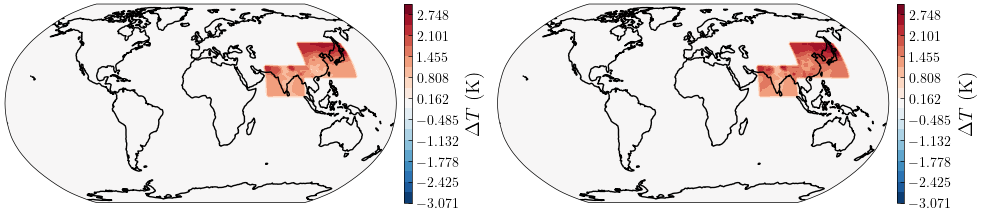

In [8]:
time_slice = slice(None, None)

xr_pred_plot = xr_pred_ESAS.isel(time=time_slice).mean(dim='time').fillna(0)
xr_gt_plot = xr_groundtruth_ESAS.isel(time=time_slice).mean(dim='time').fillna(0)
vmax = max(xr_pred_plot.values.max(), xr_gt_plot.values.max())

fig, ax = plt.subplots(1, 2, figsize=(10, 6), subplot_kw={'projection': ccrs.Robinson()})

_, __, cbar = vis.plot_contourf_on_ax(xr_pred_plot, 
                                      fig, ax[0], colorbar=True, vmax=vmax)
_, __, cbar = vis.plot_contourf_on_ax(xr_gt_plot, 
                                      fig, ax[1], colorbar=True, vmax=vmax)

plt.tight_layout()
plt.show()

In [9]:
pred_ESAS = torch.from_numpy(xr_pred_ESAS.values)
pred_ESAS = pred_ESAS[~torch.isnan(pred_ESAS)]

gt_ESAS = torch.from_numpy(xr_groundtruth_ESAS.values)
gt_ESAS = gt_ESAS[~torch.isnan(gt_ESAS)]

metrics_ssp126 = metrics.compute_deterministic_metrics(pred_ESAS, gt_ESAS)

### SSP245

In [10]:
train_cfg = {'dataset' : {'dirpath': '../data/', 'keys': ['historical', 'ssp126', 'ssp370', 'ssp585']}}
train_data = plaingp.make_data(train_cfg)

test_cfg = {'dataset' : {'dirpath': '../data/', 'keys': ['ssp245']}}
test_data = plaingp.make_data(test_cfg)

In [11]:
scenarios = train_data.scenarios
all_tas = scenarios.tas
wlat = torch.cos(torch.deg2rad(scenarios[0].lat)).clip(min=torch.finfo(torch.float64).eps)[:, None]
glob_tas = weighted_mean(all_tas, wlat)

pattern_scaling = LinearRegression()
pattern_scaling.fit(glob_tas[:, None], all_tas.reshape(all_tas.size(0), -1))

LinearRegression()

In [12]:
time_slice = slice(-21, None) # 2080-2100

pred = compute_means(test_data.scenarios, pattern_scaling)['ssp245']

xr_pred = encapsulate(pred).isel(time=time_slice)
xr_groundtruth = encapsulate(test_data.scenarios[0].tas).isel(time=time_slice)

mask = regionmask.defined_regions.srex.mask(xr_pred)
xr_pred_ESAS = xr_pred.where((mask == EAS_index) | (mask == SAS_index))
xr_groundtruth_ESAS = xr_groundtruth.where((mask == EAS_index) | (mask == SAS_index))

In [13]:
pred_ESAS = torch.from_numpy(xr_pred_ESAS.values)
pred_ESAS = pred_ESAS[~torch.isnan(pred_ESAS)]

gt_ESAS = torch.from_numpy(xr_groundtruth_ESAS.values)
gt_ESAS = gt_ESAS[~torch.isnan(gt_ESAS)]

metrics_ssp245 = metrics.compute_deterministic_metrics(pred_ESAS, gt_ESAS)

### SSP370

In [14]:
train_cfg = {'dataset' : {'dirpath': '../data/', 'keys': ['historical', 'ssp126', 'ssp245', 'ssp585']}}
train_data = plaingp.make_data(train_cfg)

test_cfg = {'dataset' : {'dirpath': '../data/', 'keys': ['ssp370']}}
test_data = plaingp.make_data(test_cfg)

In [15]:
scenarios = train_data.scenarios
all_tas = scenarios.tas
wlat = torch.cos(torch.deg2rad(scenarios[0].lat)).clip(min=torch.finfo(torch.float64).eps)[:, None]
glob_tas = weighted_mean(all_tas, wlat)

pattern_scaling = LinearRegression()
pattern_scaling.fit(glob_tas[:, None], all_tas.reshape(all_tas.size(0), -1))

LinearRegression()

In [16]:
time_slice = slice(-21, None) # 2080-2100

pred = compute_means(test_data.scenarios, pattern_scaling)['ssp370']

xr_pred = encapsulate(pred).isel(time=time_slice)
xr_groundtruth = encapsulate(test_data.scenarios[0].tas).isel(time=time_slice)

mask = regionmask.defined_regions.srex.mask(xr_pred)
xr_pred_ESAS = xr_pred.where((mask == EAS_index) | (mask == SAS_index))
xr_groundtruth_ESAS = xr_groundtruth.where((mask == EAS_index) | (mask == SAS_index))

In [17]:
pred_ESAS = torch.from_numpy(xr_pred_ESAS.values)
pred_ESAS = pred_ESAS[~torch.isnan(pred_ESAS)]

gt_ESAS = torch.from_numpy(xr_groundtruth_ESAS.values)
gt_ESAS = gt_ESAS[~torch.isnan(gt_ESAS)]

metrics_ssp370 = metrics.compute_deterministic_metrics(pred_ESAS, gt_ESAS)

### SSP585

In [18]:
train_cfg = {'dataset' : {'dirpath': '../data/', 'keys': ['historical', 'ssp126', 'ssp245', 'ssp585']}}
train_data = plaingp.make_data(train_cfg)

test_cfg = {'dataset' : {'dirpath': '../data/', 'keys': ['ssp585']}}
test_data = plaingp.make_data(test_cfg)

In [19]:
scenarios = train_data.scenarios
all_tas = scenarios.tas
wlat = torch.cos(torch.deg2rad(scenarios[0].lat)).clip(min=torch.finfo(torch.float64).eps)[:, None]
glob_tas = weighted_mean(all_tas, wlat)

pattern_scaling = LinearRegression()
pattern_scaling.fit(glob_tas[:, None], all_tas.reshape(all_tas.size(0), -1))

LinearRegression()

In [20]:
time_slice = slice(-21, None) # 2080-2100

pred = compute_means(test_data.scenarios, pattern_scaling)['ssp585']

xr_pred = encapsulate(pred).isel(time=time_slice)
xr_groundtruth = encapsulate(test_data.scenarios[0].tas).isel(time=time_slice)

mask = regionmask.defined_regions.srex.mask(xr_pred)
xr_pred_ESAS = xr_pred.where((mask == EAS_index) | (mask == SAS_index))
xr_groundtruth_ESAS = xr_groundtruth.where((mask == EAS_index) | (mask == SAS_index))

In [21]:
pred_ESAS = torch.from_numpy(xr_pred_ESAS.values)
pred_ESAS = pred_ESAS[~torch.isnan(pred_ESAS)]

gt_ESAS = torch.from_numpy(xr_groundtruth_ESAS.values)
gt_ESAS = gt_ESAS[~torch.isnan(gt_ESAS)]

metrics_ssp585 = metrics.compute_deterministic_metrics(pred_ESAS, gt_ESAS)

In [22]:
metrics_pattern_scaling = [metrics_ssp126, metrics_ssp245, metrics_ssp370, metrics_ssp585]
scores_pattern_scaling = pd.DataFrame(metrics_pattern_scaling)
scores_pattern_scaling.index = ssps
scores_pattern_scaling.index.name = 'SSP'

In [23]:
scores_pattern_scaling

,mb,rmse,mae,corr
SSP,,,,
SSP126,-0.158578,0.607803,0.481607,0.576339
SSP245,-0.039310,0.342477,0.265246,0.885117
SSP370,-0.039621,0.527583,0.409822,0.879826
SSP585,-0.486926,0.681045,0.554507,0.928672


## PlainGP

### SSP126

In [24]:
train_cfg = {'dataset' : {'dirpath': '../data/', 'keys': ['historical', 'ssp245', 'ssp370', 'ssp585']}}
train_data = plaingp.make_data(train_cfg)

test_cfg = {'dataset' : {'dirpath': '../data/', 'keys': ['ssp126']}}
test_data = plaingp.make_data(test_cfg)

model = plaingp.make_model(train_cfg, train_data)
state_dict = torch.load('../data/models/leave-one-out-ssp/ssp126/SpatialPlainGP/state_dict.pt')
model.load_state_dict(state_dict)

<All keys matched successfully>

In [25]:
test_scenarios = test_data.scenarios
Xtest = test_scenarios.glob_inputs[:, 1:]
Xtest = (Xtest - model.mu) / model.sigma
test_tas = test_scenarios.tas
model = model.eval()

In [26]:
with torch.no_grad():
    posterior = model.posterior(Xtest, diag=False)
    posterior = model.likelihood(posterior)

In [27]:
nlat = len(test_scenarios[0].lat)
nlon = len(test_scenarios[0].lon)
ntimes = len(test_scenarios[0].timesteps)
time_slice = slice(-21, None)

prior_mean = model.mu_targets.view(1, nlat, nlon).repeat(ntimes, 1, 1)
posterior_mean = posterior.mean.reshape(nlat, nlon, -1).permute(2, 0, 1)
posterior_correction =  model.sigma_targets.view(1, nlat, nlon) * posterior_mean
posterior_mean = prior_mean + posterior_mean

posterior_stddev = posterior.stddev.reshape(nlat, nlon, -1).permute(2, 0, 1)
posterior_stddev = model.sigma_targets.view(1, nlat, nlon) * posterior_stddev

prediction = torch.distributions.Normal(posterior_mean, posterior_stddev)
groundtruth = test_tas

In [28]:
time_slice = slice(-21, None)

xr_pred_mean = encapsulate(prediction.mean).isel(time=time_slice)
xr_pred_stddev = encapsulate(prediction.stddev).isel(time=time_slice)
xr_groundtruth = encapsulate(groundtruth).isel(time=time_slice)

mask = regionmask.defined_regions.srex.mask(xr_pred_mean)
xr_pred_mean_ESAS = xr_pred_mean.where((mask == EAS_index) | (mask == SAS_index))
xr_pred_stddev_ESAS = xr_pred_stddev.where((mask == EAS_index) | (mask == SAS_index))
xr_groundtruth_ESAS = xr_groundtruth.where((mask == EAS_index) | (mask == SAS_index))

In [29]:
pred_mean_ESAS = torch.from_numpy(xr_pred_mean_ESAS.values)
pred_mean_ESAS = pred_mean_ESAS[~torch.isnan(pred_mean_ESAS)]

pred_stddev_ESAS = torch.from_numpy(xr_pred_stddev_ESAS.values)
pred_stddev_ESAS = pred_stddev_ESAS[~torch.isnan(pred_stddev_ESAS)]

pred_dist = torch.distributions.Normal(pred_mean_ESAS, pred_stddev_ESAS)

gt_ESAS = torch.from_numpy(xr_groundtruth_ESAS.values)
gt_ESAS = gt_ESAS[~torch.isnan(gt_ESAS)]

metrics_ssp126 = {**metrics.compute_deterministic_metrics(pred_dist.mean, gt_ESAS),
                  **metrics.compute_probabilistic_metrics(pred_dist, gt_ESAS)}

### SSP245

In [30]:
train_cfg = {'dataset' : {'dirpath': '../data/', 'keys': ['historical', 'ssp126', 'ssp370', 'ssp585']}}
train_data = plaingp.make_data(train_cfg)

test_cfg = {'dataset' : {'dirpath': '../data/', 'keys': ['ssp245']}}
test_data = plaingp.make_data(test_cfg)

model = plaingp.make_model(train_cfg, train_data)
state_dict = torch.load('../data/models/leave-one-out-ssp/ssp245/SpatialPlainGP/state_dict.pt')
model.load_state_dict(state_dict)

<All keys matched successfully>

In [31]:
test_scenarios = test_data.scenarios
Xtest = test_scenarios.glob_inputs[:, 1:]
Xtest = (Xtest - model.mu) / model.sigma
test_tas = test_scenarios.tas
model = model.eval()

In [32]:
with torch.no_grad():
    posterior = model.posterior(Xtest, diag=False)
    posterior = model.likelihood(posterior)

In [33]:
nlat = len(test_scenarios[0].lat)
nlon = len(test_scenarios[0].lon)
ntimes = len(test_scenarios[0].timesteps)
time_slice = slice(-21, None)

prior_mean = model.mu_targets.view(1, nlat, nlon).repeat(ntimes, 1, 1)
posterior_mean = posterior.mean.reshape(nlat, nlon, -1).permute(2, 0, 1)
posterior_correction =  model.sigma_targets.view(1, nlat, nlon) * posterior_mean
posterior_mean = prior_mean + posterior_mean

posterior_stddev = posterior.stddev.reshape(nlat, nlon, -1).permute(2, 0, 1)
posterior_stddev = model.sigma_targets.view(1, nlat, nlon) * posterior_stddev

prediction = torch.distributions.Normal(posterior_mean, posterior_stddev)
groundtruth = test_tas

In [34]:
time_slice = slice(-21, None)

xr_pred_mean = encapsulate(prediction.mean).isel(time=time_slice)
xr_pred_stddev = encapsulate(prediction.stddev).isel(time=time_slice)
xr_groundtruth = encapsulate(groundtruth).isel(time=time_slice)

mask = regionmask.defined_regions.srex.mask(xr_pred_mean)
xr_pred_mean_ESAS = xr_pred_mean.where((mask == EAS_index) | (mask == SAS_index))
xr_pred_stddev_ESAS = xr_pred_stddev.where((mask == EAS_index) | (mask == SAS_index))
xr_groundtruth_ESAS = xr_groundtruth.where((mask == EAS_index) | (mask == SAS_index))

In [35]:
pred_mean_ESAS = torch.from_numpy(xr_pred_mean_ESAS.values)
pred_mean_ESAS = pred_mean_ESAS[~torch.isnan(pred_mean_ESAS)]

pred_stddev_ESAS = torch.from_numpy(xr_pred_stddev_ESAS.values)
pred_stddev_ESAS = pred_stddev_ESAS[~torch.isnan(pred_stddev_ESAS)]

pred_dist = torch.distributions.Normal(pred_mean_ESAS, pred_stddev_ESAS)

gt_ESAS = torch.from_numpy(xr_groundtruth_ESAS.values)
gt_ESAS = gt_ESAS[~torch.isnan(gt_ESAS)]

metrics_ssp245 = {**metrics.compute_deterministic_metrics(pred_dist.mean, gt_ESAS),
                  **metrics.compute_probabilistic_metrics(pred_dist, gt_ESAS)}

### SSP370

In [36]:
train_cfg = {'dataset' : {'dirpath': '../data/', 'keys': ['historical', 'ssp126', 'ssp245', 'ssp585']}}
train_data = plaingp.make_data(train_cfg)

test_cfg = {'dataset' : {'dirpath': '../data/', 'keys': ['ssp370']}}
test_data = plaingp.make_data(test_cfg)

model = plaingp.make_model(train_cfg, train_data)
state_dict = torch.load('../data/models/leave-one-out-ssp/ssp370/SpatialPlainGP/state_dict.pt')
model.load_state_dict(state_dict)

<All keys matched successfully>

In [37]:
test_scenarios = test_data.scenarios
Xtest = test_scenarios.glob_inputs[:, 1:]
Xtest = (Xtest - model.mu) / model.sigma
test_tas = test_scenarios.tas
model = model.eval()

In [38]:
with torch.no_grad():
    posterior = model.posterior(Xtest, diag=False)
    posterior = model.likelihood(posterior)

In [39]:
nlat = len(test_scenarios[0].lat)
nlon = len(test_scenarios[0].lon)
ntimes = len(test_scenarios[0].timesteps)
time_slice = slice(-21, None)

prior_mean = model.mu_targets.view(1, nlat, nlon).repeat(ntimes, 1, 1)
posterior_mean = posterior.mean.reshape(nlat, nlon, -1).permute(2, 0, 1)
posterior_correction =  model.sigma_targets.view(1, nlat, nlon) * posterior_mean
posterior_mean = prior_mean + posterior_mean

posterior_stddev = posterior.stddev.reshape(nlat, nlon, -1).permute(2, 0, 1)
posterior_stddev = model.sigma_targets.view(1, nlat, nlon) * posterior_stddev

prediction = torch.distributions.Normal(posterior_mean, posterior_stddev)
groundtruth = test_tas

In [40]:
time_slice = slice(-21, None)

xr_pred_mean = encapsulate(prediction.mean).isel(time=time_slice)
xr_pred_stddev = encapsulate(prediction.stddev).isel(time=time_slice)
xr_groundtruth = encapsulate(groundtruth).isel(time=time_slice)

mask = regionmask.defined_regions.srex.mask(xr_pred_mean)
xr_pred_mean_ESAS = xr_pred_mean.where((mask == EAS_index) | (mask == SAS_index))
xr_pred_stddev_ESAS = xr_pred_stddev.where((mask == EAS_index) | (mask == SAS_index))
xr_groundtruth_ESAS = xr_groundtruth.where((mask == EAS_index) | (mask == SAS_index))

In [41]:
pred_mean_ESAS = torch.from_numpy(xr_pred_mean_ESAS.values)
pred_mean_ESAS = pred_mean_ESAS[~torch.isnan(pred_mean_ESAS)]

pred_stddev_ESAS = torch.from_numpy(xr_pred_stddev_ESAS.values)
pred_stddev_ESAS = pred_stddev_ESAS[~torch.isnan(pred_stddev_ESAS)]

pred_dist = torch.distributions.Normal(pred_mean_ESAS, pred_stddev_ESAS)

gt_ESAS = torch.from_numpy(xr_groundtruth_ESAS.values)
gt_ESAS = gt_ESAS[~torch.isnan(gt_ESAS)]

metrics_ssp370 = {**metrics.compute_deterministic_metrics(pred_dist.mean, gt_ESAS),
                  **metrics.compute_probabilistic_metrics(pred_dist, gt_ESAS)}

### SSP585

In [42]:
train_cfg = {'dataset' : {'dirpath': '../data/', 'keys': ['historical', 'ssp126', 'ssp245', 'ssp370']}}
train_data = plaingp.make_data(train_cfg)

test_cfg = {'dataset' : {'dirpath': '../data/', 'keys': ['ssp585']}}
test_data = plaingp.make_data(test_cfg)

model = plaingp.make_model(train_cfg, train_data)
state_dict = torch.load('../data/models/leave-one-out-ssp/ssp585/SpatialPlainGP/state_dict.pt')
model.load_state_dict(state_dict)

<All keys matched successfully>

In [43]:
test_scenarios = test_data.scenarios
Xtest = test_scenarios.glob_inputs[:, 1:]
Xtest = (Xtest - model.mu) / model.sigma
test_tas = test_scenarios.tas
model = model.eval()

In [44]:
with torch.no_grad():
    posterior = model.posterior(Xtest, diag=False)
    posterior = model.likelihood(posterior)

In [45]:
nlat = len(test_scenarios[0].lat)
nlon = len(test_scenarios[0].lon)
ntimes = len(test_scenarios[0].timesteps)
time_slice = slice(-21, None)

prior_mean = model.mu_targets.view(1, nlat, nlon).repeat(ntimes, 1, 1)
posterior_mean = posterior.mean.reshape(nlat, nlon, -1).permute(2, 0, 1)
posterior_correction =  model.sigma_targets.view(1, nlat, nlon) * posterior_mean
posterior_mean = prior_mean + posterior_mean

posterior_stddev = posterior.stddev.reshape(nlat, nlon, -1).permute(2, 0, 1)
posterior_stddev = model.sigma_targets.view(1, nlat, nlon) * posterior_stddev

prediction = torch.distributions.Normal(posterior_mean, posterior_stddev)
groundtruth = test_tas

In [46]:
time_slice = slice(-21, None)

xr_pred_mean = encapsulate(prediction.mean).isel(time=time_slice)
xr_pred_stddev = encapsulate(prediction.stddev).isel(time=time_slice)
xr_groundtruth = encapsulate(groundtruth).isel(time=time_slice)

mask = regionmask.defined_regions.srex.mask(xr_pred_mean)
xr_pred_mean_ESAS = xr_pred_mean.where((mask == EAS_index) | (mask == SAS_index))
xr_pred_stddev_ESAS = xr_pred_stddev.where((mask == EAS_index) | (mask == SAS_index))
xr_groundtruth_ESAS = xr_groundtruth.where((mask == EAS_index) | (mask == SAS_index))

In [47]:
pred_mean_ESAS = torch.from_numpy(xr_pred_mean_ESAS.values)
pred_mean_ESAS = pred_mean_ESAS[~torch.isnan(pred_mean_ESAS)]

pred_stddev_ESAS = torch.from_numpy(xr_pred_stddev_ESAS.values)
pred_stddev_ESAS = pred_stddev_ESAS[~torch.isnan(pred_stddev_ESAS)]

pred_dist = torch.distributions.Normal(pred_mean_ESAS, pred_stddev_ESAS)

gt_ESAS = torch.from_numpy(xr_groundtruth_ESAS.values)
gt_ESAS = gt_ESAS[~torch.isnan(gt_ESAS)]

metrics_ssp585 = {**metrics.compute_deterministic_metrics(pred_dist.mean, gt_ESAS),
                  **metrics.compute_probabilistic_metrics(pred_dist, gt_ESAS)}

In [48]:
metrics_plaingp = [metrics_ssp126, metrics_ssp245, metrics_ssp370, metrics_ssp585]
scores_plaingp = pd.DataFrame(metrics_plaingp)
scores_plaingp.index = ssps
scores_plaingp.index.name = 'SSP'

# FaIRGP

### SSP126

In [49]:
train_cfg = {'dataset' : {'dirpath': '../data/', 'keys': ['historical', 'ssp245', 'ssp370', 'ssp585']}}
train_data = fairgp.make_data(train_cfg)

test_cfg = {'dataset' : {'dirpath': '../data/', 'keys': ['ssp126']}}
test_data = fairgp.make_data(test_cfg)

model = fairgp.make_model(train_cfg, train_data)
state_dict = torch.load('../data/models/leave-one-out-ssp/ssp126/SpatialFaIRGP/state_dict.pt')
model.load_state_dict(state_dict)

<All keys matched successfully>

In [50]:
test_scenarios = test_data.scenarios
test_tas = test_scenarios.tas

model = model.eval()
with torch.no_grad():
    posterior = model.posterior(test_scenarios, diag=False)
    posterior = model.likelihood(posterior)

In [51]:
nlat = len(test_scenarios[0].lat)
nlon = len(test_scenarios[0].lon)

prior_mean = model._compute_means(test_scenarios)['ssp126']
posterior_mean = posterior.mean.reshape(nlat, nlon, -1).permute(2, 0, 1)
posterior_correction = model.mu_targets + model.sigma_targets * posterior_mean
posterior_mean = prior_mean + posterior_correction

posterior_stddev = posterior.stddev.reshape(nlat, nlon, -1).permute(2, 0, 1)
posterior_stddev = model.sigma_targets * posterior_stddev

prediction = torch.distributions.Normal(posterior_mean, posterior_stddev)
groundtruth = test_tas

In [52]:
time_slice = slice(-21, None)

xr_pred_mean = encapsulate(prediction.mean).isel(time=time_slice)
xr_pred_stddev = encapsulate(prediction.stddev).isel(time=time_slice)
xr_groundtruth = encapsulate(groundtruth).isel(time=time_slice)

mask = regionmask.defined_regions.srex.mask(xr_pred_mean)
xr_pred_mean_ESAS = xr_pred_mean.where((mask == EAS_index) | (mask == SAS_index))
xr_pred_stddev_ESAS = xr_pred_stddev.where((mask == EAS_index) | (mask == SAS_index))
xr_groundtruth_ESAS = xr_groundtruth.where((mask == EAS_index) | (mask == SAS_index))

In [53]:
pred_mean_ESAS = torch.from_numpy(xr_pred_mean_ESAS.values)
pred_mean_ESAS = pred_mean_ESAS[~torch.isnan(pred_mean_ESAS)]

pred_stddev_ESAS = torch.from_numpy(xr_pred_stddev_ESAS.values)
pred_stddev_ESAS = pred_stddev_ESAS[~torch.isnan(pred_stddev_ESAS)]

pred_dist = torch.distributions.Normal(pred_mean_ESAS, pred_stddev_ESAS)

gt_ESAS = torch.from_numpy(xr_groundtruth_ESAS.values)
gt_ESAS = gt_ESAS[~torch.isnan(gt_ESAS)]

metrics_ssp126 = {**metrics.compute_deterministic_metrics(pred_dist.mean, gt_ESAS),
                  **metrics.compute_probabilistic_metrics(pred_dist, gt_ESAS)}

### SSP245

In [54]:
train_cfg = {'dataset' : {'dirpath': '../data/', 'keys': ['historical', 'ssp126', 'ssp370', 'ssp585']}}
train_data = fairgp.make_data(train_cfg)

test_cfg = {'dataset' : {'dirpath': '../data/', 'keys': ['ssp245']}}
test_data = fairgp.make_data(test_cfg)

model = fairgp.make_model(train_cfg, train_data)
state_dict = torch.load('../data/models/leave-one-out-ssp/ssp245/SpatialFaIRGP/state_dict.pt')
model.load_state_dict(state_dict)

<All keys matched successfully>

In [55]:
test_scenarios = test_data.scenarios
test_tas = test_scenarios.tas

model = model.eval()
with torch.no_grad():
    posterior = model.posterior(test_scenarios, diag=False)
    posterior = model.likelihood(posterior)

In [56]:
nlat = len(test_scenarios[0].lat)
nlon = len(test_scenarios[0].lon)

prior_mean = model._compute_means(test_scenarios)['ssp245']
posterior_mean = posterior.mean.reshape(nlat, nlon, -1).permute(2, 0, 1)
posterior_correction = model.mu_targets + model.sigma_targets * posterior_mean
posterior_mean = prior_mean + posterior_correction

posterior_stddev = posterior.stddev.reshape(nlat, nlon, -1).permute(2, 0, 1)
posterior_stddev = model.sigma_targets * posterior_stddev

prediction = torch.distributions.Normal(posterior_mean, posterior_stddev)
groundtruth = test_tas

In [57]:
time_slice = slice(-21, None)

xr_pred_mean = encapsulate(prediction.mean).isel(time=time_slice)
xr_pred_stddev = encapsulate(prediction.stddev).isel(time=time_slice)
xr_groundtruth = encapsulate(groundtruth).isel(time=time_slice)

mask = regionmask.defined_regions.srex.mask(xr_pred_mean)
xr_pred_mean_ESAS = xr_pred_mean.where((mask == EAS_index) | (mask == SAS_index))
xr_pred_stddev_ESAS = xr_pred_stddev.where((mask == EAS_index) | (mask == SAS_index))
xr_groundtruth_ESAS = xr_groundtruth.where((mask == EAS_index) | (mask == SAS_index))

In [58]:
pred_mean_ESAS = torch.from_numpy(xr_pred_mean_ESAS.values)
pred_mean_ESAS = pred_mean_ESAS[~torch.isnan(pred_mean_ESAS)]

pred_stddev_ESAS = torch.from_numpy(xr_pred_stddev_ESAS.values)
pred_stddev_ESAS = pred_stddev_ESAS[~torch.isnan(pred_stddev_ESAS)]

pred_dist = torch.distributions.Normal(pred_mean_ESAS, pred_stddev_ESAS)

gt_ESAS = torch.from_numpy(xr_groundtruth_ESAS.values)
gt_ESAS = gt_ESAS[~torch.isnan(gt_ESAS)]

metrics_ssp245 = {**metrics.compute_deterministic_metrics(pred_dist.mean, gt_ESAS),
                  **metrics.compute_probabilistic_metrics(pred_dist, gt_ESAS)}

### SSP370

In [59]:
train_cfg = {'dataset' : {'dirpath': '../data/', 'keys': ['historical', 'ssp126', 'ssp245', 'ssp585']}}
train_data = fairgp.make_data(train_cfg)

test_cfg = {'dataset' : {'dirpath': '../data/', 'keys': ['ssp370']}}
test_data = fairgp.make_data(test_cfg)

model = fairgp.make_model(train_cfg, train_data)
state_dict = torch.load('../data/models/leave-one-out-ssp/ssp370/SpatialFaIRGP/state_dict.pt')
model.load_state_dict(state_dict)

<All keys matched successfully>

In [60]:
test_scenarios = test_data.scenarios
test_tas = test_scenarios.tas

model = model.eval()
with torch.no_grad():
    posterior = model.posterior(test_scenarios, diag=False)
    posterior = model.likelihood(posterior)

In [61]:
nlat = len(test_scenarios[0].lat)
nlon = len(test_scenarios[0].lon)

prior_mean = model._compute_means(test_scenarios)['ssp370']
posterior_mean = posterior.mean.reshape(nlat, nlon, -1).permute(2, 0, 1)
posterior_correction = model.mu_targets + model.sigma_targets * posterior_mean
posterior_mean = prior_mean + posterior_correction

posterior_stddev = posterior.stddev.reshape(nlat, nlon, -1).permute(2, 0, 1)
posterior_stddev = model.sigma_targets * posterior_stddev

prediction = torch.distributions.Normal(posterior_mean, posterior_stddev)
groundtruth = test_tas

In [62]:
time_slice = slice(-21, None)

xr_pred_mean = encapsulate(prediction.mean).isel(time=time_slice)
xr_pred_stddev = encapsulate(prediction.stddev).isel(time=time_slice)
xr_groundtruth = encapsulate(groundtruth).isel(time=time_slice)

mask = regionmask.defined_regions.srex.mask(xr_pred_mean)
xr_pred_mean_ESAS = xr_pred_mean.where((mask == EAS_index) | (mask == SAS_index))
xr_pred_stddev_ESAS = xr_pred_stddev.where((mask == EAS_index) | (mask == SAS_index))
xr_groundtruth_ESAS = xr_groundtruth.where((mask == EAS_index) | (mask == SAS_index))

In [63]:
pred_mean_ESAS = torch.from_numpy(xr_pred_mean_ESAS.values)
pred_mean_ESAS = pred_mean_ESAS[~torch.isnan(pred_mean_ESAS)]

pred_stddev_ESAS = torch.from_numpy(xr_pred_stddev_ESAS.values)
pred_stddev_ESAS = pred_stddev_ESAS[~torch.isnan(pred_stddev_ESAS)]

pred_dist = torch.distributions.Normal(pred_mean_ESAS, pred_stddev_ESAS)

gt_ESAS = torch.from_numpy(xr_groundtruth_ESAS.values)
gt_ESAS = gt_ESAS[~torch.isnan(gt_ESAS)]

metrics_ssp370 = {**metrics.compute_deterministic_metrics(pred_dist.mean, gt_ESAS),
                  **metrics.compute_probabilistic_metrics(pred_dist, gt_ESAS)}

### SSP585

In [64]:
train_cfg = {'dataset' : {'dirpath': '../data/', 'keys': ['historical', 'ssp126', 'ssp245', 'ssp370']}}
train_data = fairgp.make_data(train_cfg)

test_cfg = {'dataset' : {'dirpath': '../data/', 'keys': ['ssp585']}}
test_data = fairgp.make_data(test_cfg)

model = fairgp.make_model(train_cfg, train_data)
state_dict = torch.load('../data/models/leave-one-out-ssp/ssp585/SpatialFaIRGP/state_dict.pt')
model.load_state_dict(state_dict)

<All keys matched successfully>

In [65]:
test_scenarios = test_data.scenarios
test_tas = test_scenarios.tas

model = model.eval()
with torch.no_grad():
    posterior = model.posterior(test_scenarios, diag=False)
    posterior = model.likelihood(posterior)

In [66]:
nlat = len(test_scenarios[0].lat)
nlon = len(test_scenarios[0].lon)

prior_mean = model._compute_means(test_scenarios)['ssp585']
posterior_mean = posterior.mean.reshape(nlat, nlon, -1).permute(2, 0, 1)
posterior_correction = model.mu_targets + model.sigma_targets * posterior_mean
posterior_mean = prior_mean + posterior_correction

posterior_stddev = posterior.stddev.reshape(nlat, nlon, -1).permute(2, 0, 1)
posterior_stddev = model.sigma_targets * posterior_stddev

prediction = torch.distributions.Normal(posterior_mean, posterior_stddev)
groundtruth = test_tas

In [67]:
time_slice = slice(-21, None)

xr_pred_mean = encapsulate(prediction.mean).isel(time=time_slice)
xr_pred_stddev = encapsulate(prediction.stddev).isel(time=time_slice)
xr_groundtruth = encapsulate(groundtruth).isel(time=time_slice)

mask = regionmask.defined_regions.srex.mask(xr_pred_mean)
xr_pred_mean_ESAS = xr_pred_mean.where((mask == EAS_index) | (mask == SAS_index))
xr_pred_stddev_ESAS = xr_pred_stddev.where((mask == EAS_index) | (mask == SAS_index))
xr_groundtruth_ESAS = xr_groundtruth.where((mask == EAS_index) | (mask == SAS_index))

In [68]:
pred_mean_ESAS = torch.from_numpy(xr_pred_mean_ESAS.values)
pred_mean_ESAS = pred_mean_ESAS[~torch.isnan(pred_mean_ESAS)]

pred_stddev_ESAS = torch.from_numpy(xr_pred_stddev_ESAS.values)
pred_stddev_ESAS = pred_stddev_ESAS[~torch.isnan(pred_stddev_ESAS)]

pred_dist = torch.distributions.Normal(pred_mean_ESAS, pred_stddev_ESAS)

gt_ESAS = torch.from_numpy(xr_groundtruth_ESAS.values)
gt_ESAS = gt_ESAS[~torch.isnan(gt_ESAS)]

metrics_ssp585 = {**metrics.compute_deterministic_metrics(pred_dist.mean, gt_ESAS),
                  **metrics.compute_probabilistic_metrics(pred_dist, gt_ESAS)}

In [69]:
metrics_fairgp = [metrics_ssp126, metrics_ssp245, metrics_ssp370, metrics_ssp585]
scores_fairgp = pd.DataFrame(metrics_fairgp)
scores_fairgp.index = ssps
scores_fairgp.index.name = 'SSP'

---

In [70]:
pattern_scaling_summary = scores_pattern_scaling.aggregate(['mean', 'std'])
gp_summary = scores_plaingp.aggregate(['mean', 'std'])
fairgp_summary = scores_fairgp.aggregate(['mean', 'std'])

scores_pattern_scaling = pd.concat([scores_pattern_scaling, pattern_scaling_summary])
scores_plaingp = pd.concat([scores_plaingp, gp_summary])
scores_fairgp = pd.concat([scores_fairgp, fairgp_summary])

In [71]:
scores_fairgp['Model'] = '2FaIRGP'
scores_plaingp['Model'] = '1Plain GP'
scores_pattern_scaling['Model'] = '0FaIR'
metrics_cols = ['Bias', 'RMSE', 'MAE', 'Corr', 'LL', 'Calib95', 'CRPS', 'ICI']
full_scores = pd.concat([scores_fairgp, scores_plaingp, scores_pattern_scaling]).sort_index().set_index('Model', append=True)
full_scores.columns = metrics_cols
full_scores = full_scores[['RMSE', 'MAE', 'Bias', 'Corr', 'LL', 'Calib95', 'CRPS']].sort_index().round(3)

In [72]:
results = full_scores[['RMSE', 'MAE', 'Bias', 'Corr', 'LL', 'Calib95', 'CRPS']].fillna('-')
results

RMSE    MAE   Bias   Corr     LL Calib95   CRPS
       Model                                                      
SSP126 0FaIR      0.608  0.482 -0.159  0.576      -       -      -
       1Plain GP  0.603  0.469 -0.104  0.560 -0.965   0.869  0.337
       2FaIRGP    0.594  0.464 -0.116  0.582 -1.003   0.811  0.336
SSP245 0FaIR      0.342  0.265 -0.039  0.885      -       -      -
       1Plain GP  0.551  0.426 -0.247  0.838 -0.991    0.77  0.312
       2FaIRGP    0.342  0.261  0.039  0.885 -0.298   0.979  0.187
SSP370 0FaIR      0.528  0.410 -0.040  0.880      -       -      -
       1Plain GP  1.092  0.879 -0.797  0.836 -2.079   0.612  0.665
       2FaIRGP    0.539  0.420  0.086  0.878 -0.945   0.834  0.304
SSP585 0FaIR      0.681  0.555 -0.487  0.929      -       -      -
       1Plain GP  1.338  0.989 -0.720  0.505 -2.049   0.677  0.751
       2FaIRGP    0.796  0.636 -0.578  0.902  -2.09   0.611  0.487
mean   0FaIR      0.540  0.428 -0.181  0.817      -       -      -
       1Plain GP  0.896  0.691 -0.467  0.685 -1.521   0.732  0.516
       2FaIRGP    0.568  0.445 -0.142  0.812 -1.084   0.809  0.329
std    0FaIR      0.146  0.123  0.211  0.162      -       -      -
       1Plain GP  0.382  0.285  0.343  0.178  0.627   0.112  0.225
       2FaIRGP    0.187  0.154  0.303  0.153  0.743   0.151  0.124